#Conectamos a google drive e importamos librerias

In [ ]:
# Se conecta al Drive:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(2)
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pickle #para guardado de datos
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from keras.layers.core import Dense, Flatten, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Conv2D, AveragePooling2D, BatchNormalization, Dropout, MaxPooling2D,RandomFlip,RandomRotation,MaxPool2D
from keras.applications.vgg16 import VGG16

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Para importar el Helper
%cd "/content/drive/Shareddrives/Redes neuronales/TP3"
!pip install import-ipynb
import import_ipynb
from Helper import *

/content/drive/Shareddrives/Redes neuronales/TP3
  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-py3-none-any.whl size=2975 sha256=3e586bc55a077da581d0d55b93cd4e7de2d50586cb21113c6b533641cce39692
  Stored in directory: /root/.cache/pip/wheels/b1/5e/dc/79780689896a056199b0b9f24471e3ee184fbd816df355d5f0
Successfully built import-ipynb
importing Jupyter notebook from Helper.ipynb
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 16)   448         ['input_1[0][0]']                
                                                                                                

# Cargamos los datos

In [ ]:
X_train = np.load("/content/drive/Shareddrives/Redes neuronales/TP3/Dataset original/X_train.npy")
Y_train = np.load("/content/drive/Shareddrives/Redes neuronales/TP3/Dataset original/y_train.npy")
X_test = np.load("/content/drive/Shareddrives/Redes neuronales/TP3/Dataset original/X_test.npy")

# Dividimos entre datasets de entrenamiento y validación

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size = 0.1)

# Paso a float

In [ ]:
x_train = x_train.astype('float32')
x_valid = x_valid.astype('float32')
x_test = X_test.astype('float32')
x_train /= 255
x_valid /= 255
x_test /= 255

In [ ]:
y_train_categorical = to_categorical(y_train,100)
y_val_categorical = to_categorical(y_valid,100)

# Data gen

Usamos la función ImageDataGenerator de keras para aumentar la cantidad de datos de entrada disponibles. Podemos rotar, hacer flips de la imagen, zoom, entre otros (listados en la función de abajo). La idea es que podemos entrenar el modelo por ejempo con la foto de un perro mirando de derecha a izquierda y tambien con la misma foto de izquierda a derecha, pues sigue siendo un perro!

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180) #30
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=3/32,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0,  # randomly shift images vertically (fraction of total height) #0.1
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


x_train_pp = x_train
datagen.fit(x_train_pp)

# x_test_pp = x_test
# datagen.fit(x_test_pp)

#  Modelo VGG16

En el caso de este script elegimos el modelo VGG16 de keras. Lo elegimos porque se considera que es una de las mejores arquitecturas de modelos hasta la fecha

In [ ]:
preproc=VGG16(include_top = False, pooling = None, weights="imagenet",input_shape=(32,32,3))
preproc.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                              

In [ ]:
for layer in preproc.layers:
    layer.trainable=False

In [ ]:
x_pre_train=preproc.predict(x_train_pp)
x_pre_valid=preproc.predict(x_valid)

In [ ]:
x_pre_train[0].shape

(1, 1, 512)

In [ ]:
input_preproc=Input(shape=(1,1,512))

net=Flatten()(input_preproc)

net=Dense(units=256, activation='relu')(net)
net=Dropout(0.2)(net)
net=Dense(units=256, activation='relu')(net)
net=Dropout(0.2)(net)
net=Dense(units=100, activation = 'softmax')(net)

model=Model(input_preproc,net)

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1, 1, 512)]       0         
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 100)               2570

# Primer entrenamiento

En este caso elegimos utilizar transfer learning que busca una red neuronal que acelere el aprendizaje y se otorgan valores de inicio a los parámetros que sirvan como variables de entrada para las diferentes capas de la red (se busca un punto de partida óptimo).

In [ ]:
# Callbacks
checkpoint_file =f"/content/drive/Shareddrives/Redes neuronales/TP3/Modelos entrenados/transfer_learning_dataaug.hdf5"

earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=2)
checkpointer = ModelCheckpoint(monitor="val_accuracy",filepath=checkpoint_file, verbose=1, save_best_only=True)

In [ ]:
batch_size = 100
epocs = 100

history = model.fit(x_pre_train, 
        y_train_categorical,
        epochs=epocs, batch_size=batch_size, 
        verbose=1, 
        validation_data = (x_pre_valid, y_val_categorical),
        callbacks=[checkpointer, earlystop],
    )

Epoch 1/100
441/450 [============================>.] - ETA: 0s - loss: 4.5899 - accuracy: 0.0207
Epoch 00001: val_accuracy improved from -inf to 0.05600, saving model to /content/drive/Shareddrives/Redes neuronales/TP3/Modelos entrenados/transfer_learning_dataaug.hdf5
450/450 [==============================] - 3s 5ms/step - loss: 4.5891 - accuracy: 0.0206 - val_loss: 4.5084 - val_accuracy: 0.0560
Epoch 2/100
442/450 [============================>.] - ETA: 0s - loss: 4.4709 - accuracy: 0.0455
Epoch 00002: val_accuracy improved from 0.05600 to 0.08900, saving model to /content/drive/Shareddrives/Redes neuronales/TP3/Modelos entrenados/transfer_learning_dataaug.hdf5
450/450 [==============================] - 2s 4ms/step - loss: 4.4694 - accuracy: 0.0458 - val_loss: 4.3491 - val_accuracy: 0.0890
Epoch 3/100
450/450 [==============================] - ETA: 0s - loss: 4.2940 - accuracy: 0.0664
Epoch 00003: val_accuracy improved from 0.08900 to 0.11580, saving model to /content/drive/Shareddri

# Resultados 1

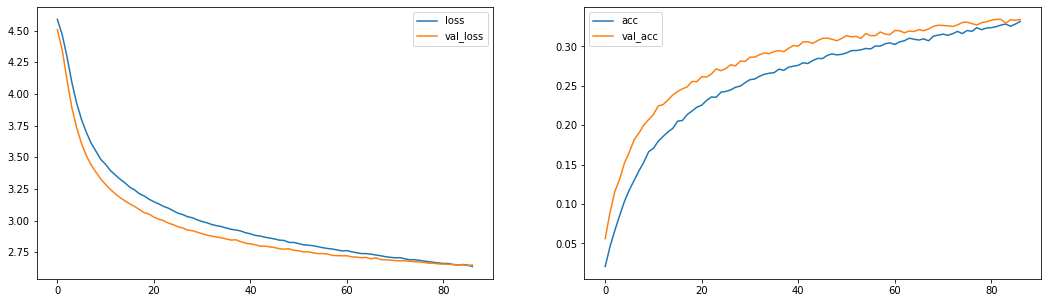

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(18,5))
ax1.plot(history.history['loss'], label="loss")
ax1.plot(history.history['val_loss'], label="val_loss")
ax1.legend()

ax2.plot(history.history['accuracy'], label="acc")
ax2.plot(history.history['val_accuracy'], label="val_acc")
ax2.legend()
plt.show();

In [ ]:
model.load_weights(checkpoint_file)

# 2do modelo

In [ ]:
total_model_output=model(preproc.output)
total_model=Model(preproc.input,total_model_output)
total_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

In [ ]:
for layer in preproc.layers:
    layer.trainable=True
total_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

# 2do entrenamiento

In [ ]:
total_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
# Callbacks
# checkpoint_file='/content/drive/Shareddrives/Redes neuronales/TP3/Modelos entrenados/cifar10-cnn-TL-VGG16_fine_tunning-Carli.hdf5'
checkpoint_file=f'/content/drive/Shareddrives/Redes neuronales/TP3/Modelos entrenados/cifar10-cnn-TL-VGG16_fine_tunning_batch_size{batch_size}_epocs{epocs}_optimizer"sgd"_neuronas512Carli.hdf5'
earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=2)
checkpointer = ModelCheckpoint(monitor="val_accuracy",filepath=checkpoint_file, verbose=1, save_best_only=True)

In [ ]:
batch_size = 100
epocs = 100

history = total_model.fit(x_train_pp, 
        y_train_categorical,
        epochs=epocs, batch_size=batch_size, 
        verbose=1, 
        validation_data = (x_valid, y_val_categorical),
        callbacks=[checkpointer, earlystop],
    )

Epoch 1/100
450/450 [==============================] - ETA: 0s - loss: 3.0293 - accuracy: 0.2580
Epoch 00001: val_accuracy improved from -inf to 0.35580, saving model to /content/drive/Shareddrives/Redes neuronales/TP3/Modelos entrenados/cifar10-cnn-TL-VGG16_fine_tunning_batch_size100_epocs100_optimizer"sgd"_neuronas512Carli.hdf5
450/450 [==============================] - 56s 115ms/step - loss: 3.0293 - accuracy: 0.2580 - val_loss: 2.4856 - val_accuracy: 0.3558
Epoch 2/100
450/450 [==============================] - ETA: 0s - loss: 2.2472 - accuracy: 0.4003
Epoch 00002: val_accuracy improved from 0.35580 to 0.42680, saving model to /content/drive/Shareddrives/Redes neuronales/TP3/Modelos entrenados/cifar10-cnn-TL-VGG16_fine_tunning_batch_size100_epocs100_optimizer"sgd"_neuronas512Carli.hdf5
450/450 [==============================] - 51s 114ms/step - loss: 2.2472 - accuracy: 0.4003 - val_loss: 2.1418 - val_accuracy: 0.4268
Epoch 3/100
450/450 [==============================] - ETA: 0s - 

# Resultados

In [ ]:
path_results = "/content/drive/Shareddrives/Redes neuronales/TP3/Submissions/sumbission_cnn-TL-VGG16_fine_tunning_carli_rotation__carli_1.csv"

checkpoint_file=f'/content/drive/Shareddrives/Redes neuronales/TP3/Modelos entrenados/cifar10-cnn-TL-VGG16_fine_tunning_batch_size{100}_epocs{100}_optimizer"sgd"_neuronas512Carli.hdf5'
path_model = checkpoint_file
results = predic(x_test,path_results,total_model,path_model)
results

,label
Id,
0,12
1,84
2,27
3,91
4,71
...,...
9995,83
9996,14
9997,51


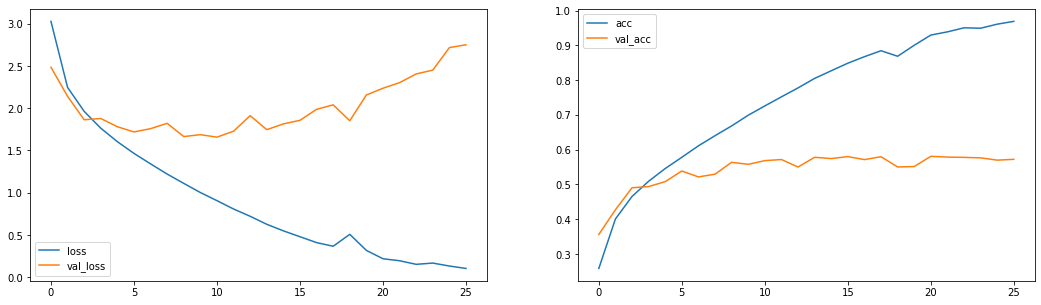

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(18,5))
ax1.plot(history.history['loss'], label="loss")
ax1.plot(history.history['val_loss'], label="val_loss")
ax1.legend()

ax2.plot(history.history['accuracy'], label="acc")
ax2.plot(history.history['val_accuracy'], label="val_acc")
ax2.legend()
plt.show();